## Customer Churn Prediction - Full Python script


Loading dataset from telco_customer_churn.csv ...

==== Basic EDA ====
Shape: (5000, 21)

Sample rows:
                               0                 1                          2
customerID            CUST100000        CUST100001                 CUST100002
gender                      Male            Female                       Male
SeniorCitizen                  0                 0                          0
Partner                       No                No                        Yes
Dependents                    No               Yes                        Yes
tenure                        16                57                         57
PhoneService                 Yes                No                         No
MultipleLines                 No                No                         No
InternetService              DSL               DSL                Fiber optic
OnlineSecurity                No                No                         No
OnlineBackup                 Yes       

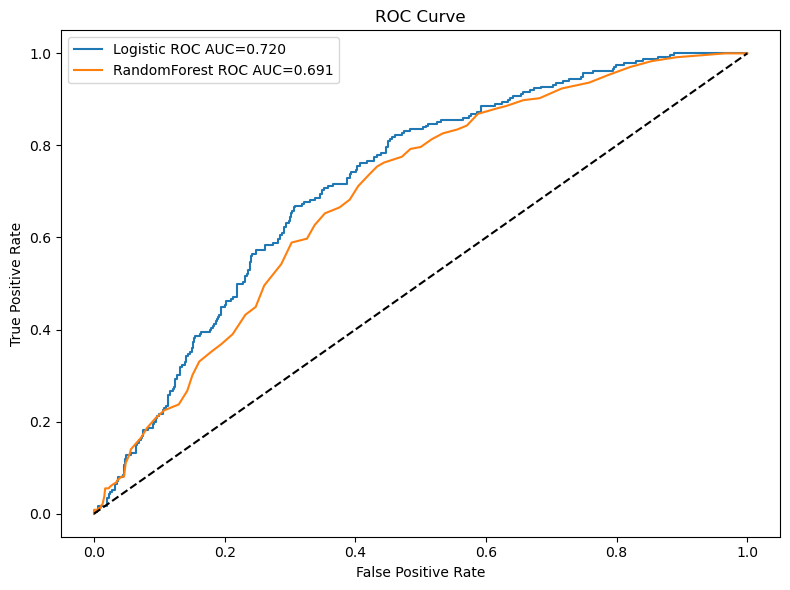

In [2]:
"""
Customer Churn Prediction - Full Python script
Author: Generated for Kumar Saurabh
Description:
- Loads a Telco-style churn CSV if present (telco_customer_churn.csv)
- If CSV not found, creates a synthetic Telco-like dataset and saves it as telco_customer_churn.csv
- Performs data cleaning, preprocessing, EDA summaries (prints), model training (Logistic Regression & Random Forest)
- Evaluates models (accuracy, classification report, confusion matrix, ROC AUC)
- Saves trained models to disk (joblib)
- Ready to upload to GitHub as a standalone project file

How to run:
1. Place 'telco_customer_churn.csv' in the same folder as this script (optional).
2. pip install -r requirements.txt (scikit-learn, pandas, numpy, matplotlib, seaborn, joblib)
3. python customer_churn_full_project.py
"""

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib





def create_synthetic_telco(path="telco_customer_churn.csv", n=5000, random_state=42):
    """Creates a synthetic telco-style churn dataset and saves to CSV."""
    np.random.seed(random_state)
    customerID = [f"CUST{100000+i}" for i in range(n)]
    gender = np.random.choice(["Male", "Female"], size=n)
    SeniorCitizen = np.random.choice([0,1], size=n, p=[0.84, 0.16])
    Partner = np.random.choice(["Yes","No"], size=n, p=[0.48, 0.52])
    Dependents = np.random.choice(["Yes","No"], size=n, p=[0.25, 0.75])
    tenure = np.random.randint(0, 72, size=n)
    PhoneService = np.random.choice(["Yes","No"], size=n, p=[0.9,0.1])
    MultipleLines = np.random.choice(["Yes","No","No phone service"], size=n, p=[0.2,0.7,0.1])
    InternetService = np.random.choice(["DSL","Fiber optic","No"], size=n, p=[0.34,0.5,0.16])
    OnlineSecurity = np.where(InternetService=="No","No internet service", np.random.choice(["Yes","No"], size=n, p=[0.35,0.65]))
    OnlineBackup = np.where(InternetService=="No","No internet service", np.random.choice(["Yes","No"], size=n, p=[0.34,0.66]))
    DeviceProtection = np.where(InternetService=="No","No internet service", np.random.choice(["Yes","No"], size=n, p=[0.3,0.7]))
    TechSupport = np.where(InternetService=="No","No internet service", np.random.choice(["Yes","No"], size=n, p=[0.3,0.7]))
    StreamingTV = np.where(InternetService=="No","No internet service", np.random.choice(["Yes","No"], size=n, p=[0.4,0.6]))
    StreamingMovies = np.where(InternetService=="No","No internet service", np.random.choice(["Yes","No"], size=n, p=[0.4,0.6]))
    Contract = np.random.choice(["Month-to-month","One year","Two year"], size=n, p=[0.55,0.25,0.2])
    PaperlessBilling = np.random.choice(["Yes","No"], size=n, p=[0.6,0.4])
    PaymentMethod = np.random.choice(["Electronic check","Mailed check","Bank transfer (automatic)","Credit card (automatic)"], size=n)
    MonthlyCharges = np.round(np.random.uniform(20,120,size=n) + (tenure==0)*10,2)
    TotalCharges = np.round(MonthlyCharges * tenure + np.random.uniform(-10,50,size=n),2)
    # churn probability influenced by month-to-month, higher monthly charges, low tenure, electronic check
    churn_prob = (Contract=="Month-to-month")*0.25 + (InternetService=="Fiber optic")*0.08 + (MonthlyCharges>80)*0.08 + (PaymentMethod=="Electronic check")*0.05 + (tenure<6)*0.1
    churn = np.where(np.random.rand(n) < churn_prob, "Yes", "No")

    df = pd.DataFrame({
        "customerID": customerID,
        "gender": gender,
        "SeniorCitizen": SeniorCitizen,
        "Partner": Partner,
        "Dependents": Dependents,
        "tenure": tenure,
        "PhoneService": PhoneService,
        "MultipleLines": MultipleLines,
        "InternetService": InternetService,
        "OnlineSecurity": OnlineSecurity,
        "OnlineBackup": OnlineBackup,
        "DeviceProtection": DeviceProtection,
        "TechSupport": TechSupport,
        "StreamingTV": StreamingTV,
        "StreamingMovies": StreamingMovies,
        "Contract": Contract,
        "PaperlessBilling": PaperlessBilling,
        "PaymentMethod": PaymentMethod,
        "MonthlyCharges": MonthlyCharges,
        "TotalCharges": TotalCharges,
        "Churn": churn
    })

    df.to_csv(path, index=False)
    print(f"Synthetic dataset saved to {path} (rows: {len(df)})")
    return df

def load_data(path="telco_customer_churn.csv"):
    if os.path.exists(path):
        print(f"Loading dataset from {path} ...")
        df = pd.read_csv(path)
    else:
        print(f"{path} not found. Creating a synthetic dataset instead...")
        df = create_synthetic_telco(path=path)
    return df

def basic_eda(df):
    print("\n==== Basic EDA ====")
    print("Shape:", df.shape)
    print("\nSample rows:")
    print(df.head(3).T)
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print("\nTarget distribution (Churn):")
    print(df['Churn'].value_counts(normalize=True))
    print("\nNumeric summary:")
    print(df.select_dtypes(include=[np.number]).describe().T)

def preprocess(df):
    df = df.copy()
    # Common Telco dataset quirks: TotalCharges may be object if blank. Convert safely.
    if 'TotalCharges' in df.columns:
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        # If NaNs, fill with MonthlyCharges * tenure
        df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])

    # Drop customerID if present
    if 'customerID' in df.columns:
        df = df.drop(columns=['customerID'])

    # Target encode
    df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

    # Identify categorical and numerical columns
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Churn' in num_cols:
        num_cols.remove('Churn')

    print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
    print(f"Numerical columns ({len(num_cols)}): {num_cols}")

    # Fill missing categorical with 'Missing'
    df[cat_cols] = df[cat_cols].fillna('Missing')

    # Simple encoding: OneHot for categorical small-cardinality, leave numerical scaled later
    return df, cat_cols, num_cols

def build_and_evaluate(df, cat_cols, num_cols, do_gridsearch=False):
    X = df[cat_cols + num_cols]
    y = df['Churn']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\nTrain/Test sizes: {X_train.shape}/{X_test.shape}  |  Positive rate in test: {y_test.mean():.3f}")

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

    # Logistic Regression pipeline
    pipe_lr = Pipeline(steps=[('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
    pipe_rf = Pipeline(steps=[('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42))])

    print("\nTraining Logistic Regression...")
    pipe_lr.fit(X_train, y_train)
    y_pred_lr = pipe_lr.predict(X_test)
    y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]

    print("Training Random Forest...")
    pipe_rf.fit(X_train, y_train)
    y_pred_rf = pipe_rf.predict(X_test)
    y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

    # Evaluation helper
    def eval_model(name, y_true, y_pred, y_proba):
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_proba)
        print(f"\n{name} - Accuracy: {acc:.4f}  |  ROC AUC: {auc:.4f}")
        print("Classification report:\n", classification_report(y_true, y_pred))
        print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
        return acc, auc

    lr_acc, lr_auc = eval_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
    rf_acc, rf_auc = eval_model("Random Forest", y_test, y_pred_rf, y_proba_rf)

    # Feature importance for Random Forest (need to get column names after preprocessing)
    # Get feature names
    ohe = pipe_rf.named_steps['pre'].named_transformers_['cat']
    if hasattr(ohe, 'get_feature_names_out'):
        cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
    else:
        # fallback
        cat_feature_names = []
    feature_names = num_cols + cat_feature_names
    try:
        importances = pipe_rf.named_steps['clf'].feature_importances_
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
        print("\nTop feature importances (Random Forest):")
        print(feat_imp)
    except Exception as e:
        print("Could not compute feature importances:", e)
        feat_imp = None

    # Save models
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    joblib.dump(pipe_lr, os.path.join(model_dir, "logistic_pipeline.joblib"))
    joblib.dump(pipe_rf, os.path.join(model_dir, "random_forest_pipeline.joblib"))
    print(f"\nSaved trained models to ./{model_dir}/")

    # Plot ROC curves
    plt.figure(figsize=(8,6))
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic ROC AUC={lr_auc:.3f}')
    plt.plot(fpr_rf, tpr_rf, label=f'RandomForest ROC AUC={rf_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    print("ROC curve saved to roc_curve.png")

    return {
        "lr_acc": lr_acc, "lr_auc": lr_auc,
        "rf_acc": rf_acc, "rf_auc": rf_auc,
        "feature_importance": feat_imp
    }

def main():
    df = load_data("telco_customer_churn.csv")
    basic_eda(df)
    df_processed, cat_cols, num_cols = preprocess(df)
    results = build_and_evaluate(df_processed, cat_cols, num_cols)
    print("\n==== Summary ====")
    print("Logistic Regression - Accuracy:", results['lr_acc'], "AUC:", results['lr_auc'])
    print("Random Forest - Accuracy:", results['rf_acc'], "AUC:", results['rf_auc'])
    if results['feature_importance'] is not None:
        print("\nTop features saved above.")

if __name__ == '__main__':
    main()
